### Project goal: Forecast the temperatures for Berlin-Tempelhof

Exercise in three notebooks:
1. Inspect the raw data and apply trend, seasonality and AR modelling manually and automatically using `statsmodels` package to predict temperature.
2. Use ARIMA and SARIMAX modelling to predict temperature.
3. Plot the predicted temperatures using Plotly

This is notebook 1.

In [49]:
# Imports
from datetime import datetime
from helper_functions.load_data import load_data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg

In [50]:
# Functions
def test_stationarity(
    data: pd.DataFrame, test: str, regression: str = "ct", autolag: str = "AIC"
) -> None:
    """
    Performs and prints results of either one of two Unit root tests:
    an augmented Dickey-Fuller test or an Kwiatkowski-Philips-Schmidt-Shin test.

    Parameters
    ----------
    data : pd.DataFrame
        Data on which the test is to be performed on.
    test : str,
        Which test to perform: "adfuller" or "kpss".
    regression : str
        Regression parameter passed onto the adfuller or kpss.
    autolag : str, optional
        Estimator criterion for errors, only for adfuller,
        by default "AIC".
    """
    if test == "adfuller":
        results = adfuller(x=data, regression=regression, autolag=autolag)
        print(f"Adfuller Test Statistic: {results[0]}")
        print(f"p-value: {results[1]:.4f}")
        print(f"Lags used: {results[2]}")
        print(f"N observations: {results[3]}")
        print("Critical Values (Inverse CI level / Test statistic):")
        for key, value in results[4].items():
            print(f"{key}: {value:.3f}")
        print(f"Max. Information Criterion {autolag}: {results[5]}")
    elif test == "kpss":
        results = kpss(x=data, regression=regression)
        print(f"KPSS Test Statistic: {results[0]}")
        print(f"p-value: {results[1]:.4f}")
        print(f"Lags used: {results[2]}")
        print("Critical Values (Inverse CI level / Test statistic):")
        for key, value in results[3].items():
            print(f"{key}: {value:.3f}")
    else:
        ValueError("Test type unknown.")


def get_pred_linear_model(X: pd.DataFrame, y: pd.DataFrame):
    """
        Wrapper to obtain predictions from a linear model.

    Parameters
    ----------
    X : pd.DataFrame
        X Data
    y : pd.DataFrame
        y Data

    Returns
    -------
    Model and predictions
    """
    model = LinearRegression()
    model.fit(X, y)

    return model, model.predict(X)

#### Read in data and do some transformations

In [51]:
# Read file
FILEPATH = "TG_STAID002759.txt"
SUBFOLDER = "data/"
with open(SUBFOLDER + FILEPATH, "r") as f:
    content = f.readlines()

# Find row at which the data starts
for idx, item in enumerate(content):
    if "SOUID," in item:
        index = idx
        break
# Load the data, fix column names, and use DATE column as DateTimeIndex
df = load_data(FILEPATH, subfolder=SUBFOLDER, skiprows=index, sep=",")
df.columns = [
    x.split(" ")[-1] for x in df.columns
]  # actual column name is always at the end after x whitespaces
df = df.set_index(pd.to_datetime(df["DATE"].astype(str))).drop("DATE", axis=1)

Loading in TG_STAID002759.txt...
Data set successfully loaded.



Remove missing temperature data and convert the remaining temperatures to full °C (were given in .1°C) and drop missing data.
Note: Dropping data might be a slight be an issue for our modelling, so either we start after the missing temperature values (i.e. after the war 1946). Or we interpolate the data by replacing the missing data with the average seasonality from other years where we actually have data. For now we drop.

In [52]:
df = df.loc[df["Q_TG"] != 9]
df["TG"] = df["TG"] / 10  # or *.1

Exclude 2022 data for "future" predictions later on, drop unnecessary columns. Then split the data in training and test set but only get data right after the last missing temperature value and finish by ploting the test data.

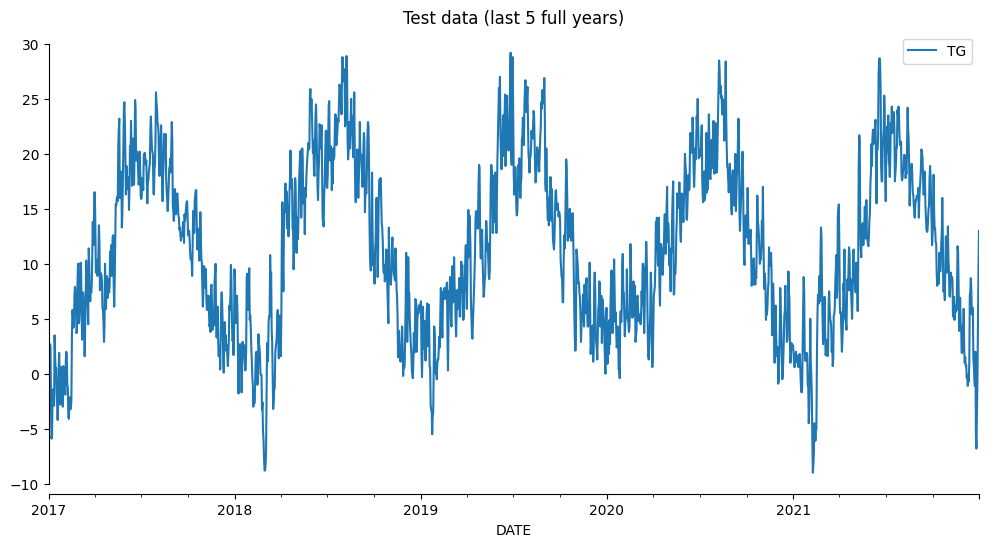

In [53]:
df = df.drop(["Q_TG", "SOUID"], axis=1)
df_train = df.loc["1950-01-01":"2016-12-31"]
df_test = df.loc["2017-01-01":"2021-12-31"]
df_test.plot(figsize=(12, 6), title="Test data (last 5 full years)")
sns.despine(trim=True)

There's a lot of daily noise, for better visualization lets average and use histogramms to get a feeling for the distribution of temperatures.

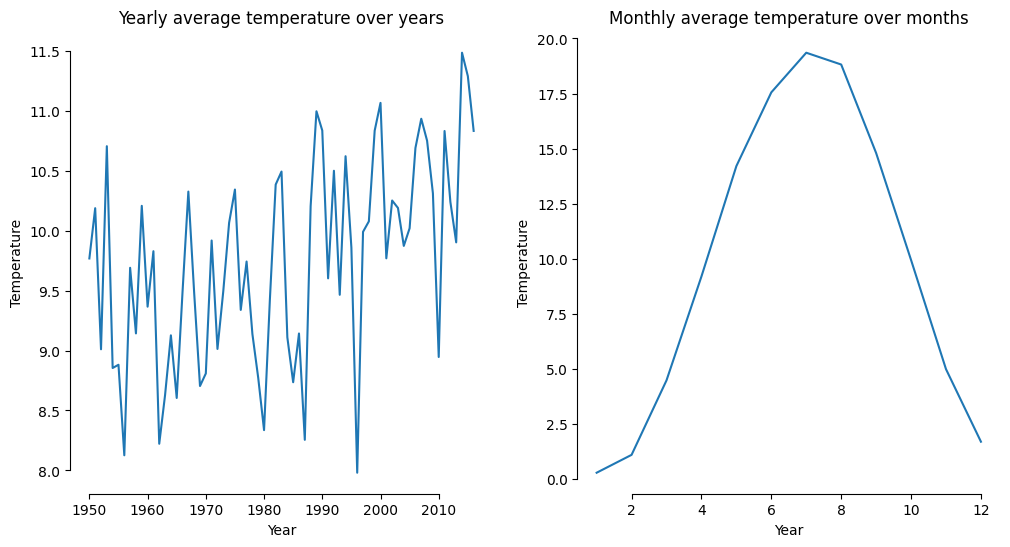

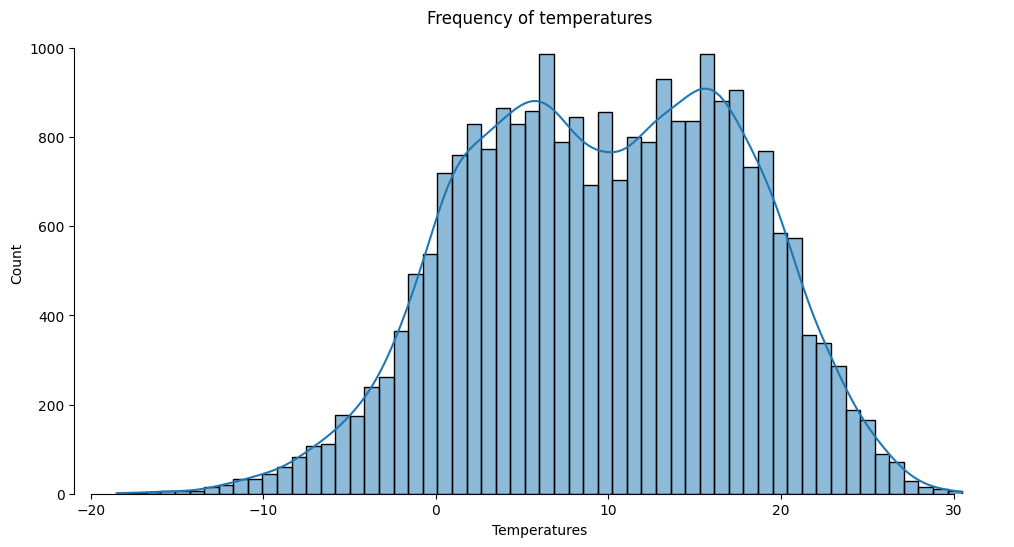

In [54]:
_fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
df_train.groupby(df_train.index.year)["TG"].mean().plot(
    ax=ax1,
    title="Yearly average temperature over years",
    ylabel="Temperature",
    xlabel="Year",
)
df_train.groupby(df_train.index.month)["TG"].mean().plot(
    ax=ax2,
    title="Monthly average temperature over months",
    ylabel="Temperature",
    xlabel="Year",
)
sns.despine(trim=True)
_fig, ax3 = plt.subplots(figsize=(12, 6))
sns.histplot(df_train["TG"], ax=ax3, kde=True)
ax3.set_title("Frequency of temperatures")
ax3.set_ylabel("Count")
ax3.set_xlabel("Temperatures")
sns.despine(trim=True)

We can state the obvious: like almost all temperature time series, **this time series is non-stationary**.
Stationarity implies that there is NO underlying mean trend in the time series which can either be a marked by the presence of a unit root or of a deterministic trend.
For in-depth explanation see the wikipedia entry and https://en.wikipedia.org/wiki/Stationary_process#/media/File:Stationarycomparison.png
Examples for *weakly stationary* data are Gaussian noise or white noise while examples for *Non-Stationary* data are temperature or random walk time-series.

What's a unit root?  
We can express the linear model as an equation in which model factors are expressed differently such that we better understand some of its properties: for example, if a factor's root is larger than 1 (unit root), the equation moves the data away from the mean, making it non-stationary. If it is below 1, it moves towards zero (or not away from the mean) and is therefore stationary. Note that this is just one aspect of it, so check wiki page for a more complete understanding.
Only once we have established trend stationary in the time series, we can apply AR modelling in a meaningful way to capture information/patterns we otherwise could not. This is because only then we satisfy the requirement that we need to always draw from the same distribution (e.g., gaussian normal-distribution) as part of the stochastic process in AR-modelling.

There is two ways to check for stationarity in the data
1. Look at autoregression and/or partial autoregression plots.
2. Assess stationarity statistically with the augmented Dickey-Fuller test and the KPSS test.
In practice, they are used complementary not exclusively.

<br><br>
However, before we do that, let's see whether we can actually remove some of what is making the time series non-stationary. We see a slow linear trend upwards across years which we might be able to capture by modelling a simple timestep feature (i.e., simply +1 for each time point on the DateTimeIndex). Next, we see yearly seasonality that oscillates reguarly over years. We might be able to capture this by creating monthly dummy vars:

In [55]:
df_train["timestep"] = list(range(len(df_train)))

seasonal_feat = pd.get_dummies(df_train.index.month_name(), drop_first=True).set_index(
    df_train.index
)
df_train = df_train.join(seasonal_feat)

C:\Users\miche\AppData\Local\Temp\ipykernel_11008\3442131786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["timestep"] = list(range(len(df_train)))


We now run a simple OLS/Linear model to see how well our engineered features capture the non-stationarity. For an easier evaluation of the success of this step we will arbitrarily choose a 15-year period, plot the captured trend, as well as the residual:

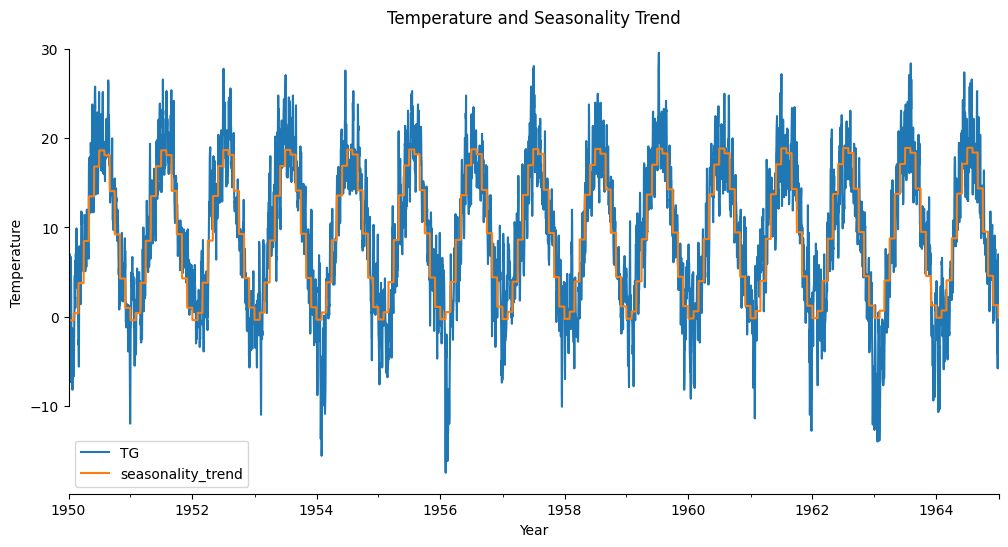

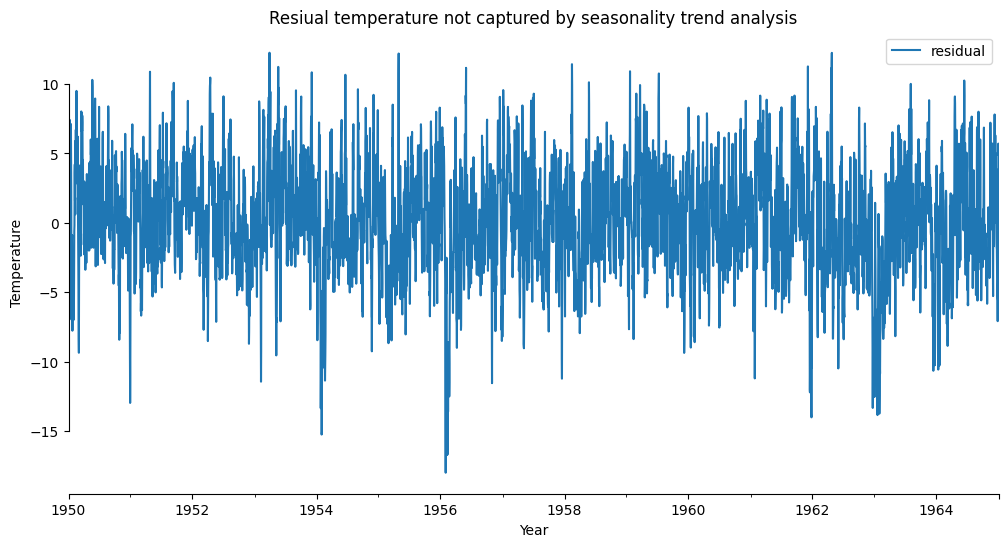

In [56]:
model_seasonality, df_train["seasonality_trend"] = get_pred_linear_model(
    X=df_train.drop(columns=["TG"]), y=df_train["TG"]
)
df_train["residual"] = df_train["TG"] - df_train["seasonality_trend"]
_fig, ax4 = plt.subplots(figsize=(12, 6))
df_train[["TG", "seasonality_trend"]].loc[:"1965-01-01"].plot(
    ax=ax4,
    title="Temperature and Seasonality Trend",
    ylabel="Temperature",
    xlabel="Year",
)
sns.despine(trim=True)
_fig, ax5 = plt.subplots(figsize=(12, 6))
df_train[["residual"]].loc[:"1965-01-01"].plot(
    ax=ax5,
    title="Residual temperature not captured by seasonality trend analysis",
    ylabel="Temperature",
    xlabel="Year",
)
sns.despine(trim=True)

It seems like we caught the trend reasonably well. Let's check whether our remainder is already stationary. As mentioned, it is generally good to apply both practices outlined above. We will start with ploting autocorrelation and partial autocorrelation and then move on to the statistical test for stationarity. 

The autocorrelation graphs how much close in time data points correlate with each other. For that, we shift each individual time point X points in time forward and correlated n-1 backwards in time (i.e., earlier time points). Another way of expressing this is to look for correlations between lagged time points. What we want to look for are values that fall outside of our Confidence Intervals (shaded area), because these may contain pattern information that we can model. However, autocorrelations plots (ACF) alone do not provide an obvious way to assess which shifts/lags should and should therefore not be used for this type of interpretation. Partial autocorrelation (PACF) does a better job at this. Looking at a lag in partial autocorrelation plots means that the values of the time series at all shorter lags (and its combined lags?) relative to the lag we are looking at have progressively been regresses out. So, it controls for other lags, which is not done by regular autocorrelations.

c:\Users\miche\anaconda3\envs\spiced_academy\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


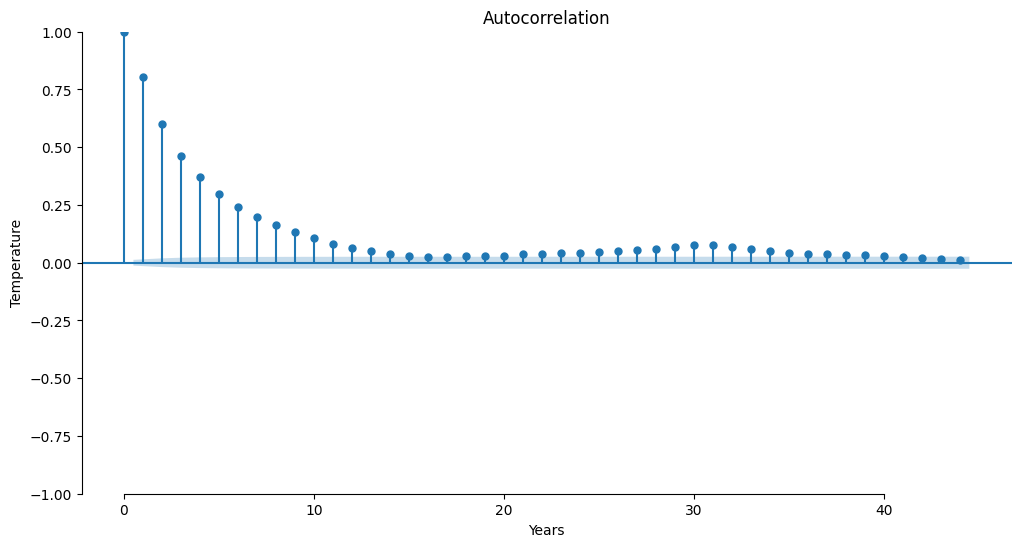

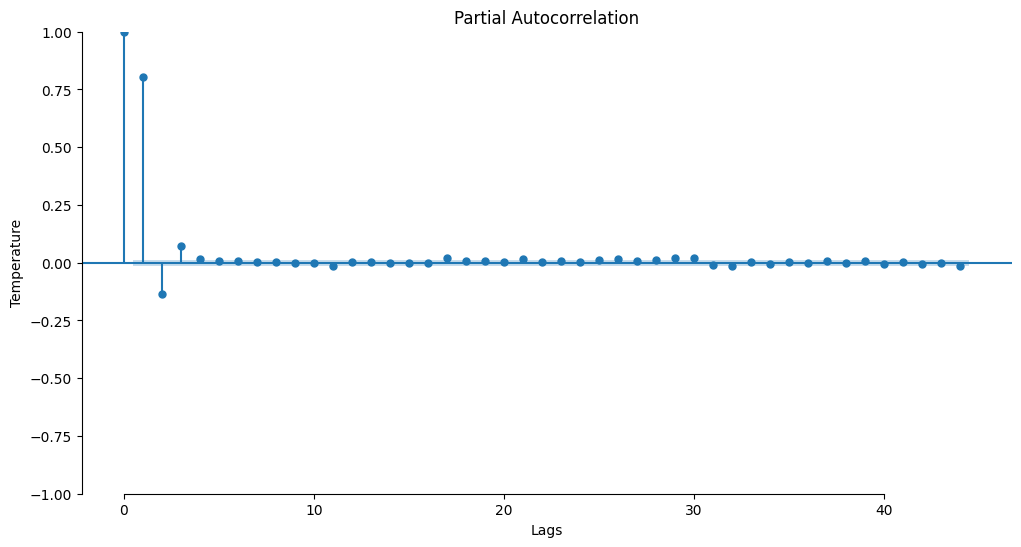

In [57]:

_fig, ax6 = plt.subplots(figsize=(12, 6))
plot_acf(df_train["residual"], ax=ax6, alpha=0.05)
ax6.set_ylabel("Temperature")
ax6.set_xlabel("Lags")
sns.despine(trim=True)
_fig, ax7 = plt.subplots(figsize=(12, 6))
plot_pacf(df_train["residual"], ax=ax7, alpha=0.05)
ax7.set_ylabel("Temperature")
ax7.set_xlabel("Lags")
sns.despine(trim=True)

Based on these plots, it appears that lag 1 and 2 are likely candidates to be modelled successfully. Possibly lag 3 as well.

We can now statistically test for stationarity of a time series using the augmented Dickey-Fuller test. H0 = there is a unit root, i.e. data = not stationary, H1 = there is no unit root, i.e. data is stationary: reject H0 with p < .05. Note: As usual with null-hypothesis testing, we can only reject the null hypothesis but not confirm the specific H1. Meaning, if p < .05, we can state that the time series is not NOT-stationary. But we cannot say for certain it is stationary.

Test the remainder for stationarity:

In [58]:
test_stationarity(test="adfuller", data=df_train["residual"], autolag="AIC", regression="ct")

Adfuller Test Statistic: -22.465418244425035
p-value: 0.0000
Lags used: 31
N observations: 24440
Critical Values (Inverse CI level / Test statistic):
1%: -3.959
5%: -3.411
10%: -3.127
Max. Information Criterion AIC: 110229.58318556493


The test statistics are outside the confidence interval at multiple levels (i.e., smaller) => p-value is smaller than all CI levels. This means: indeed, the remainder is stationary. We can move on to the AR modelling process. Note that this test establish stationarity "relatively quickly" even when the data still show a slow trend over time. I.e. it is not the end-all test. At that point, it is also useful to apply the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test. It tests the following: H0 = the time series is trend stationary, H1 = the time series has a unit root, i.e. it is not trend stationary: reject H0 with p < .05.

In [59]:
test_stationarity(test="kpss", data=df_train["residual"], regression="ct")

KPSS Test Statistic: 0.14348599987872623
p-value: 0.0547
Lags used: 70
Critical Values (Inverse CI level / Test statistic):
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


The test just misses the significance level, meaning we cannot reject the H0 that our remainder is trend stationary which reaffirms the results from the Dickey-Fuller test.

We could now simply run statsmodels AutoReg model function that does the shifting/lagging for us. This is done by calling statsmodels.tsa.ar_model import AutoReg. When fitting the AutoReg you can simply specify your lag (e.g. lag=X parameter), get the model_summary() and compare AIC / BIC to see which model is better. However, for this exercise we first do it manually. Later, we do it automatically.
Let's first shift the data with lags=3, remove newly created NaNs and plot their correlations:

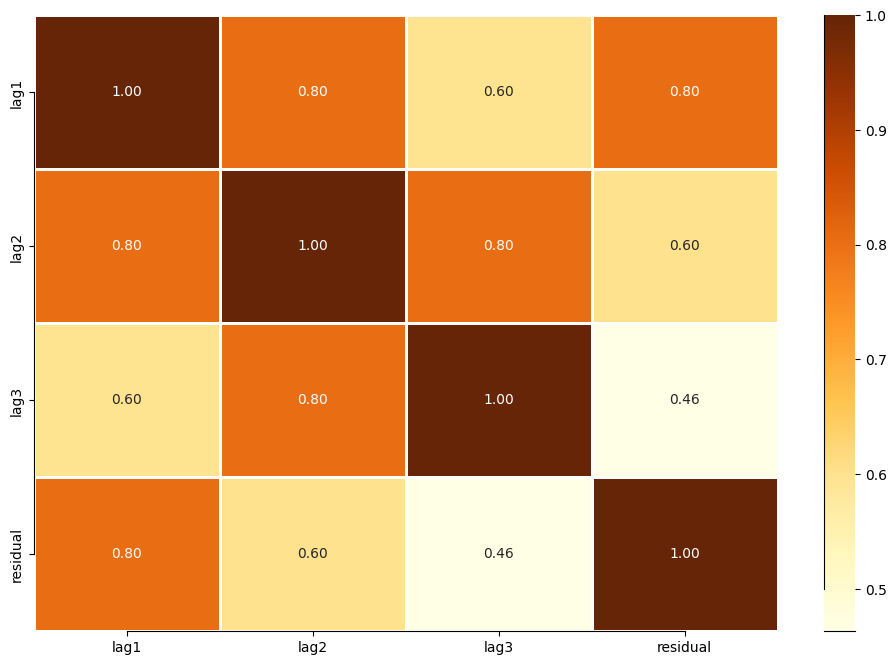

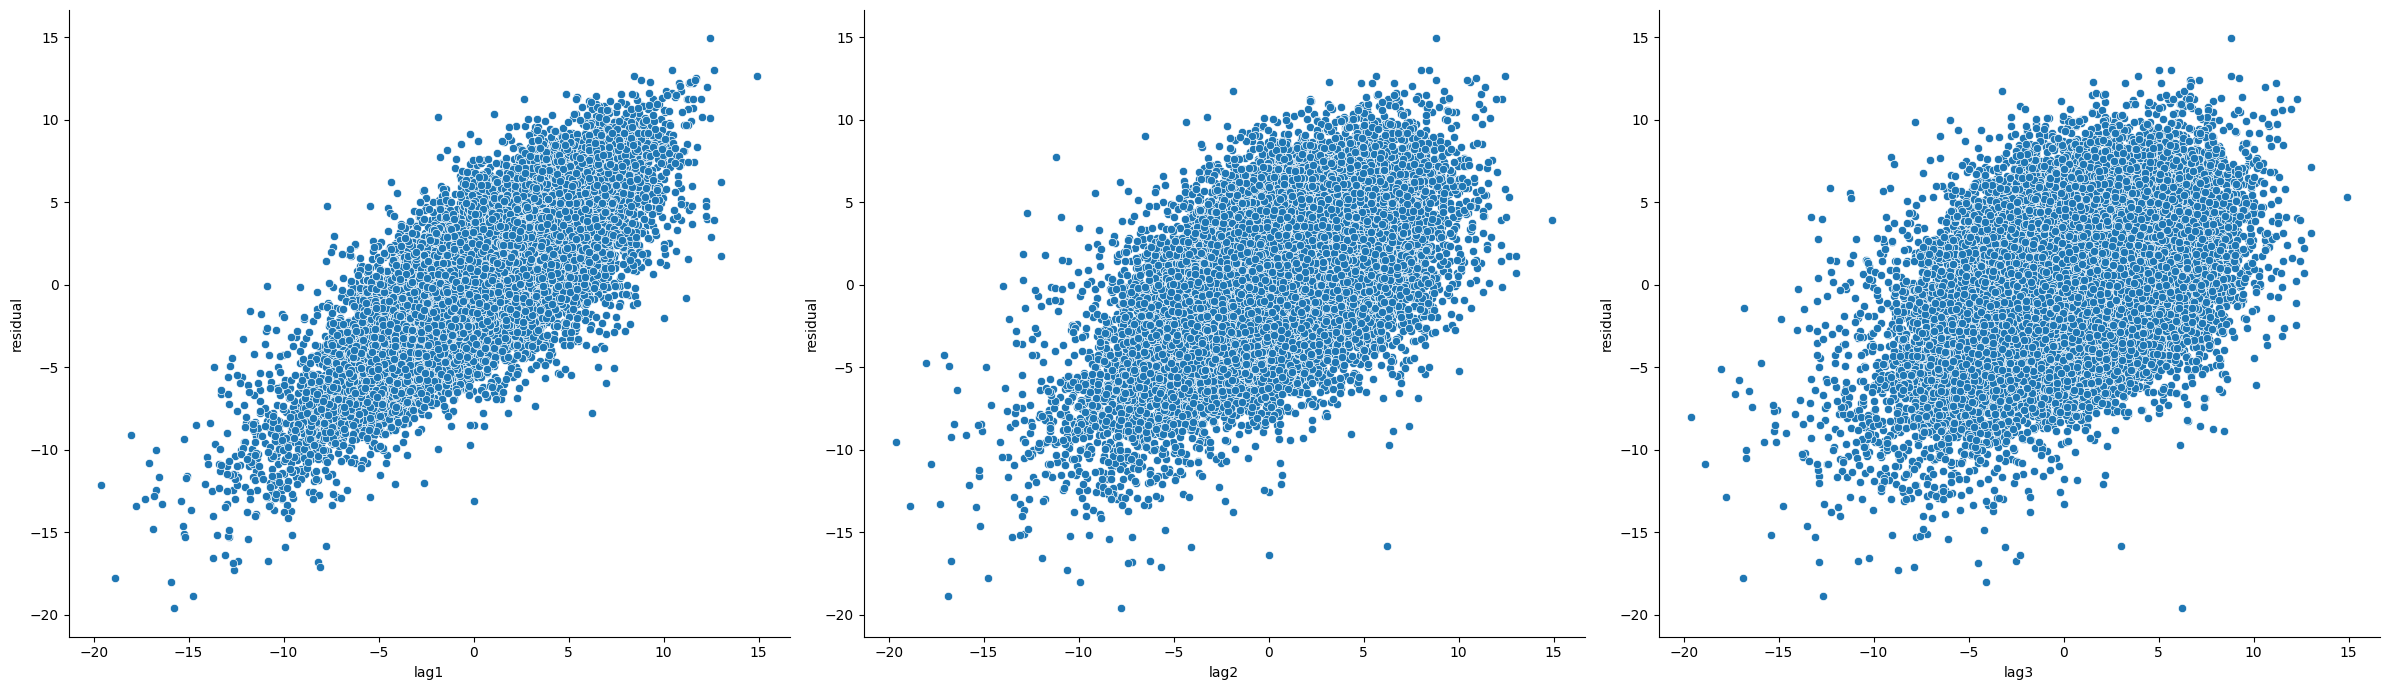

In [60]:

df_train["lag1"] = df_train["residual"].shift(1)
df_train["lag2"] = df_train["residual"].shift(2)
df_train["lag3"] = df_train["residual"].shift(3)
df_train = df_train.dropna()  # NaNs introduced through shifting at the beginning of the lags
_fig, ax8 = plt.subplots(figsize=(12, 8))
sns.heatmap(
    df_train[["lag1", "lag2", "lag3", "residual"]].corr(),
    ax=ax8,
    annot=True,
    fmt=".2f",
    lw=1,
    linecolor="white",
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
)
sns.despine(trim=True)
# Another way of representing this is by plotting the remainder against the lags
fig, (ax9, ax10, ax11) = plt.subplots(figsize=(24, 7), ncols=3)
sns.scatterplot(data=df_train, x="lag1", y="residual", ax=ax9)
sns.scatterplot(data=df_train, x="lag2", y="residual", ax=ax10)
sns.scatterplot(data=df_train, x="lag3", y="residual", ax=ax11)
plt.tight_layout()
sns.despine()

We can indeed still observe a pattern in the remainder.
Let's try to capture this with a model and plot performance exemplified by the last year.

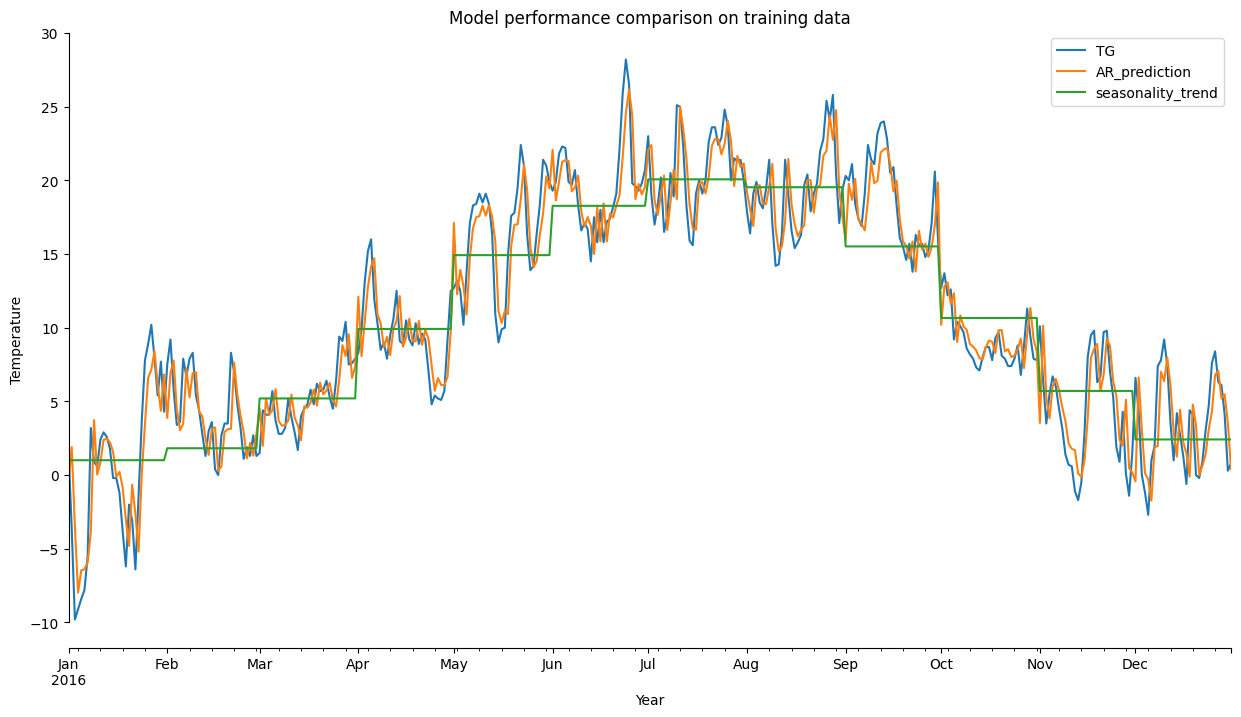

In [61]:
X = df_train.drop(columns=["seasonality_trend", "residual", "TG"])
y = df_train["TG"]
ar1_model, df_train["AR_prediction"] = get_pred_linear_model(X=X, y=y)
df_train.loc[df_train.index.year == df_train.index.year[-1]][
    ["TG", "AR_prediction", "seasonality_trend"]
].plot(
    figsize=(15, 8),
    title="Model performance comparison on training data",
    ylabel="Temperature",
    xlabel="Year",
)
sns.despine(trim=True)

It is clear that the AR prediction adds something to the model above and beyond our seasonality and trend alone. To be sure we didn't get "lucky" on our particular split, we split the time-series (using Sklearn's TimeSeriesSplit()) and cross-validate:

In [62]:
cv_splitter = TimeSeriesSplit(n_splits=5).split(X, y)
cv_results = cross_val_score(estimator=LinearRegression(), X=X, y=y, cv=cv_splitter)
print("Each cv run:\n", cv_results, "\nAverage r-squared score:\n", cv_results.mean())

Each cv run:
 [0.91314947 0.90990443 0.90628185 0.91418321 0.92216975] 
Average r-squared score:
 0.9131377433526675


It is clear: including lags/AR model-derived feature helps significantly.

Let's test our model on unseen data. But before we can use the model on the test data, we need to make sure that we have the same feature columns in the test as in the training data. Note that for features that are derived from modelled data, we should obviously use the already on df_train trained model. This concerns seasonality trend, remainder and its lags.

So let's create...

In [63]:
# ... the timestep feature
df_test["timestep"] = list(
    range(df_train["timestep"].max() + 1, df_train["timestep"].max() + len(df_test) + 1)
)
# ... the monthly features
seasonal_dummies = pd.get_dummies(df_test.index.month_name(), drop_first=True).set_index(
    df_test.index
)
df_test = df_test.join(seasonal_dummies)
# ... the seasonality trend using the already trained model
df_test["seasonality_trend"] = model_seasonality.predict(df_test.drop("TG", axis=1))
# ... the remainder
df_test["residual"] = df_test["TG"] - df_test["seasonality_trend"]
# ... and the lags of the remainder
df_test["lag1"] = df_test["residual"].shift(1)
df_test["lag2"] = df_test["residual"].shift(2)
df_test["lag3"] = df_test["residual"].shift(3)

C:\Users\miche\AppData\Local\Temp\ipykernel_11008\2028149253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["timestep"] = list(


Due to shifting, we got NaNs again, but since we didn't drop them from the y_test data, we should also not drop them here but impute them. If our test data is data that is more recent than the training data, there is no feature leakage when we propagate information forward in time (e.g., from training to test data). In other words, we could simply impute the NaNs by replacing them with the remainder from the last day of our training data and consequently the lags with their lag-1.

In [64]:
df_test.loc["2017-01-01", "lag1"] = df_train.loc["2016-12-31", "residual"]
df_test.loc["2017-01-02", "lag2"] = df_train.loc["2016-12-31", "residual"]
df_test.loc["2017-01-03", "lag3"] = df_train.loc["2016-12-31", "residual"]
df_test.loc["2017-01-01", "lag2"] = df_train.loc["2016-12-31", "lag1"]
df_test.loc["2017-01-02", "lag3"] = df_train.loc["2016-12-31", "lag1"]
df_test.loc["2017-01-01", "lag3"] = df_train.loc["2016-12-31", "lag2"]

We are ready to make predictions on the test data and evaluate them.

Seasonality Trend Model (r2 / MSE):
		0.7625 / 13.9894
Autoregressive Model (r2 / MSE):
		0.9180 / 4.8280


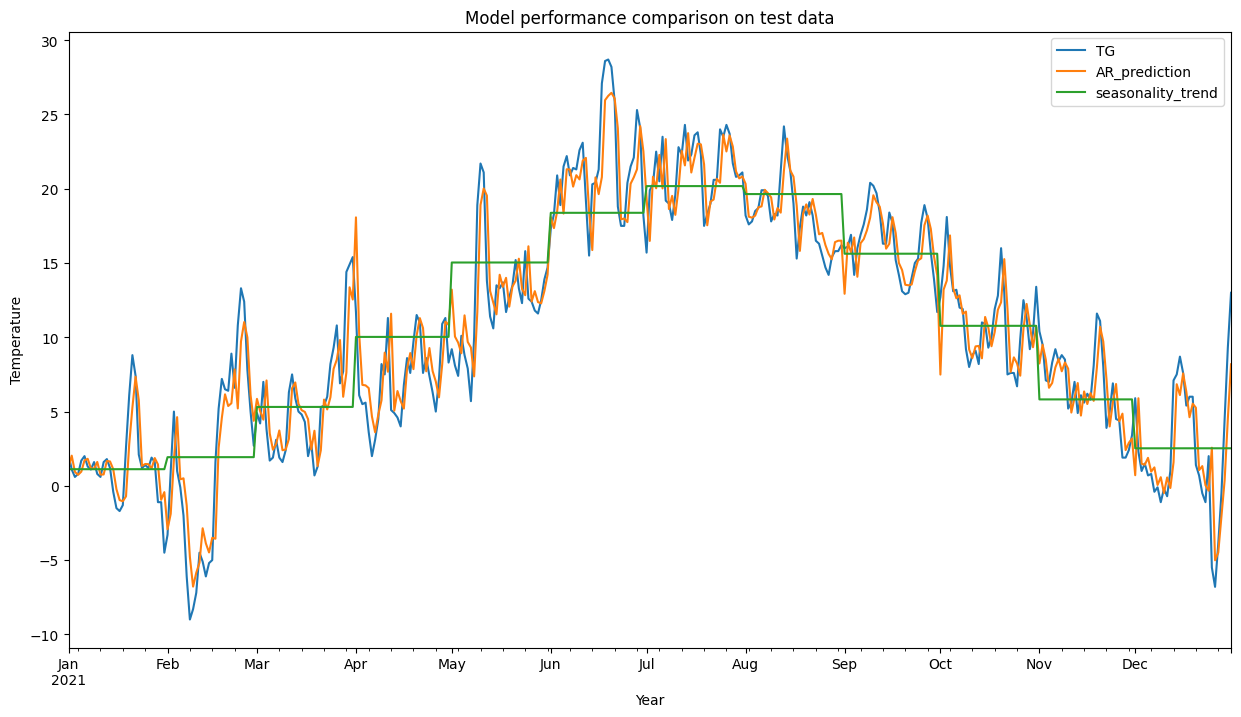

In [65]:
X_test = df_test.drop(["TG", "seasonality_trend", "residual"], axis=1)
df_test["AR_prediction"] = ar1_model.predict(X_test)
df_test.loc[df_test.index.year == df_test.index.year[-1]][
    ["TG", "AR_prediction", "seasonality_trend"]
].plot(
    figsize=(15, 8),
    title="Model performance comparison on test data",
    ylabel="Temperature",
    xlabel="Year",
)
print(
    "Seasonality Trend Model (r2 /"
    f" MSE):\n\t\t{r2_score(df_test['TG'], df_test['seasonality_trend']):.4f} /"
    f" {mean_squared_error(df_test['TG'], df_test['seasonality_trend']):.4f}"
)
print(
    "Autoregressive Model (r2 /"
    f" MSE):\n\t\t{r2_score(df_test['TG'], df_test['AR_prediction']):.4f} /"
    f" {mean_squared_error(df_test['TG'], df_test['AR_prediction']):.4f}"
)

This looks fairly good. So let's do another test and train the model on all data to predict the "future". The future is data from 2022 but we pretend we don't have the data. To get a prediction, we would need to rebuild a time point again, row by row (or time point by time point).

In [66]:
df_all = pd.concat([df_train, df_test])
model_AR_all, predictions = get_pred_linear_model(
    X=df_all.drop(columns=["TG", "seasonality_trend", "residual", "AR_prediction"]),
    y=df_all["TG"],
)
# Build X dataframe
days = pd.date_range(df_all.index[-1], datetime.now(), freq="1D") + pd.DateOffset(1)
a = np.empty((len(days)))
a[:] = np.nan
df_prediction = pd.DataFrame({"days": days, "TG": a})
df_prediction = df_prediction.set_index("days")
# ... the timestep
df_prediction["timestep"] = list(
    range(df_all["timestep"].max() + 1, df_all["timestep"].max() + len(df_prediction) + 1)
)
# ... the monthly features
seasonal_dummies = pd.get_dummies(df_prediction.index.month_name(), drop_first=True).set_index(
    df_prediction.index
)
df_prediction = df_prediction.join(seasonal_dummies)
df_to_predict = pd.DataFrame([df_prediction.iloc[0, :].drop("TG").astype(int)])
# The lags for the first row
df_to_predict["lag1"] = df_all.loc["2021-12-31", "residual"]
df_to_predict["lag2"] = df_all.loc["2021-12-31", "lag1"]
df_to_predict["lag3"] = df_all.loc["2021-12-31", "lag2"]
# Predict temperature
DATE_TO_PREDICT = "2022-01-01"
current_prediction = model_AR_all.predict(df_to_predict)[0]
df_prediction.iloc[0, 0] = current_prediction
print(
    f"Our prediction for {DATE_TO_PREDICT} is {current_prediction:.1f}°C and the actual"
    f" temperature was {df.loc[DATE_TO_PREDICT]['TG']}°C"
)

Our prediction for 2022-01-01 is 9.7°C and the actual temperature was 12.0°C


One could think now to rebuild more and more days. In fact, the code so far is built with that in minde. But how would we obtain lags?
We would need to come up with a value for TG, or temperature, to model trend and seasonality, and to calculate the remainder to obtain the lags. We could do this simply by feeding# the predicted temperature from the model. However, this would inject the originally found pattern into the dataset based on which we update our new model for the next day. This approach would get us more predictions but the model would quickly become inflexible. Moreover, it would certainly very quickly lead to poor performance.
It should be noted that the above described way is inappropriate for when data is not known (i.e. you actual try to predict new values), but it can be a good way to validate your model when withheld data is actually known, see this article for more details: https://sarit-maitra.medium.com/take-time-series-a-level-up-with-walk-forward-validation-217c33114f68

Before we continue, save all dataframes

In [67]:
df_train.to_pickle("df_train.pkl")
df_test.to_pickle("df_test.pkl")
df_all.to_pickle("df_all.pkl")

So far we implemented autoregression manually. This time, let's use the AutoReg model from statsmodels to do the heavy-lifting for us. The most seasonality action happens across months, rather than days while the overall trend is likely similarly reflected in days and month. Thus, let's resample to months first so we also don't need to adjust the period factor of the model.

                            AutoReg Model Results                             
Dep. Variable:                     TG   No. Observations:                  804
Model:               Seas. AutoReg(3)   Log Likelihood               -1638.895
Method:               Conditional MLE   S.D. of innovations              1.872
Date:                Tue, 20 Dec 2022   AIC                           3311.789
Time:                        10:01:21   BIC                           3391.449
Sample:                    04-30-1950   HQIC                          3342.389
                         - 12-31-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2921      0.416     -3.108      0.002      -2.107      -0.477
trend          0.0013      0.000      4.274      0.000       0.001       0.002
s(2,12)        1.4493      0.376      3.855      0.0

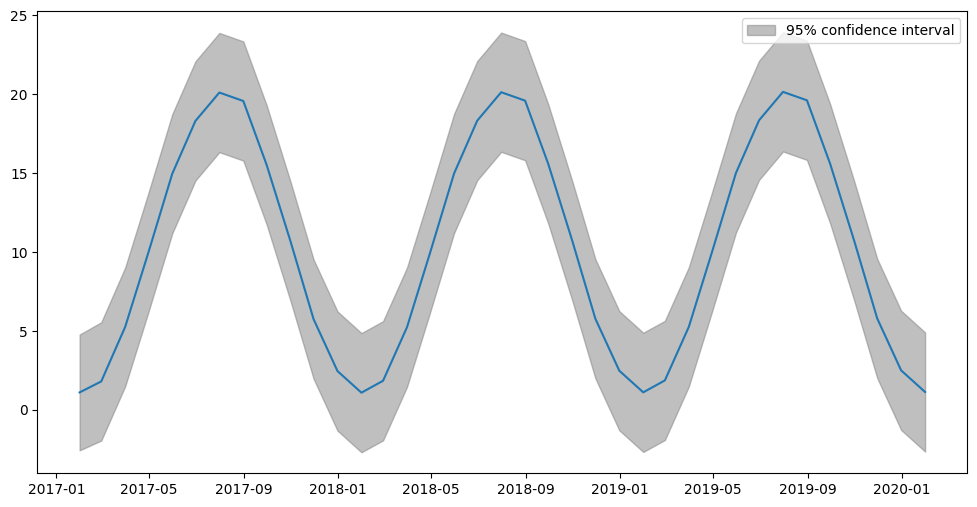

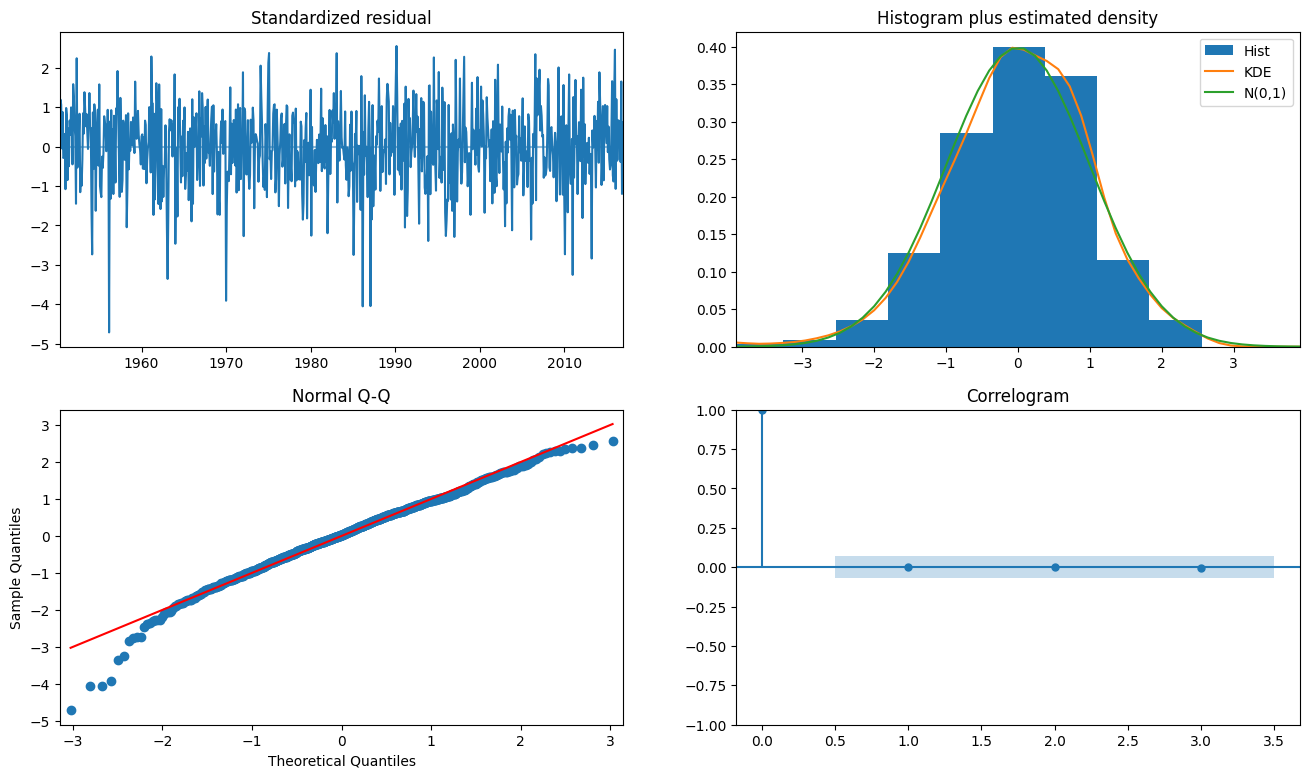

In [68]:
PERIOD = 12
LAGS = 3
df_train_resample = df_train.resample(rule="M").mean()
# Now fit the model and evaluate it
stats_AR_model = AutoReg(
    df_train_resample["TG"],
    trend="ct",
    seasonal=True,
    period=PERIOD,
    lags=LAGS,
    missing="drop",
)
res = stats_AR_model.fit()
print(res.summary())
print(f"AIC: {res.aic:.3f}, HQIC: {res.hqic:.3f}, BIC: {res.bic:.3f}")
# Let's get more visual evaluation information
fig = res.plot_predict(start="2017-01-01", end="2020-01-01", figsize=(12, 6))
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=LAGS)

We've plotted diagnostics along with the model output. What do the graphs mean? 

Most of them we've seen before but the diagnostics are interpreted as follows:  

*Top left*: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.  
*Top Right*: The density plot indicating distribution, that is whether it is normal and/or centered around 0.  
*Bottom left*: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.  
*Bottom Right*: The Correlogram, aka, ACF plot shows whether the residual errors are autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.  

Looks like we are doing very well with this model. Now, that we see that the model appears relatively good, we can make a forecast and evaluate it.
For that, we'll again plot the temperature residual of prediction against the real observations to see how good our forecast is.

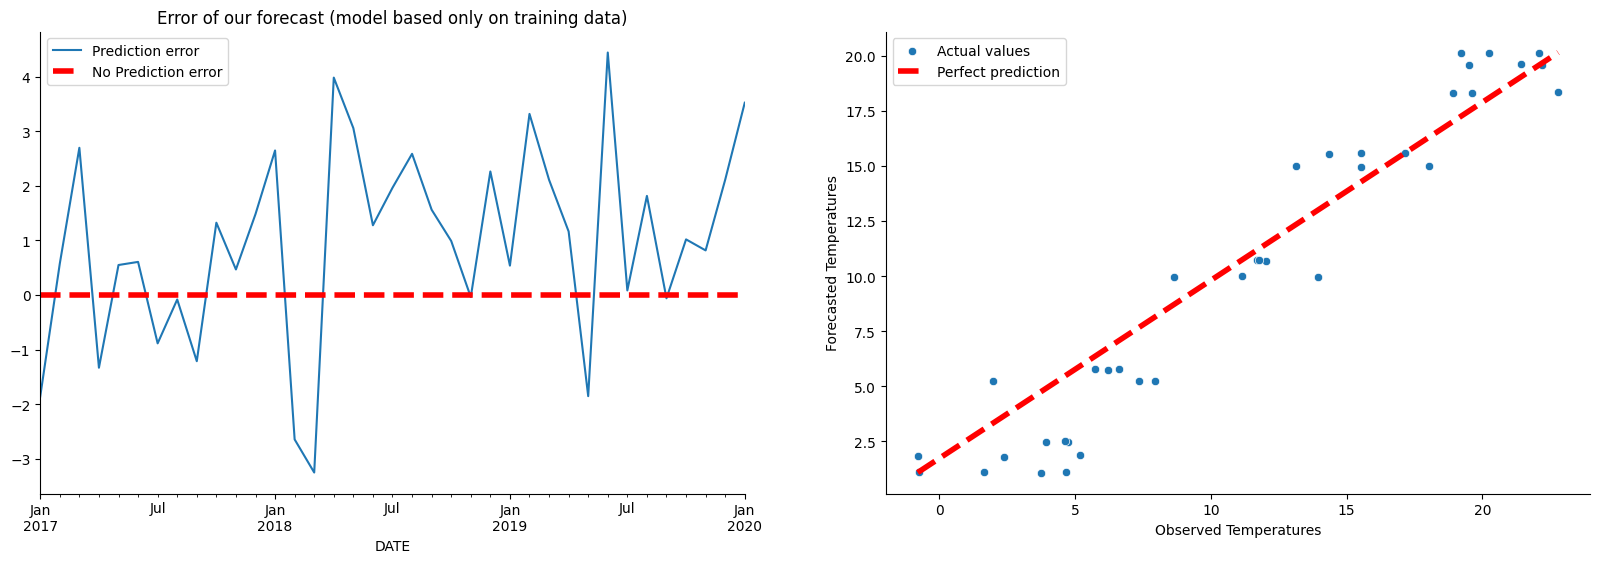

In [69]:
predictions = res.predict(start="2017-01-01", end="2020-01-01")
df_test_resample = df_test.resample(rule="M").mean()
error = df_test_resample["TG"].loc["2017-01-01":"2020-02-01"].values - predictions.values
error = pd.DataFrame(
    error,
    columns=["Prediction error"],
    index=df_test_resample["TG"].loc["2017-01-01":"2020-02-01"].index,
)
error["Observed Temperatures"] = df_test_resample["TG"].loc["2017-01-01":"2020-02-01"].values
error["Forecasted Temperatures"] = predictions.values
_fig, (ax11, ax12) = plt.subplots(figsize=(20, 6), ncols=2)
error["Prediction error"].plot(
    ax=ax11, title="Error of our forecast (model based only on training data)"
)
ax11.axhline(
    0,
    color="red",
    linestyle="--",
    label="No Prediction error",
    lw=4,
)
ax11.legend(loc="upper left")
sns.scatterplot(
    data=error,
    x="Observed Temperatures",
    y="Forecasted Temperatures",
    ax=ax12,
    label="Actual values",
)
sns.lineplot(
    x=[
        float(error["Observed Temperatures"].min()),
        float(error["Observed Temperatures"].max()),
    ],
    y=[
        float(error["Forecasted Temperatures"].min()),
        float(error["Forecasted Temperatures"].max()),
    ],
    ax=ax12,
    errorbar=None,
    linestyle="--",
    lw=4,
    color="red",
    label="Perfect prediction",
)
sns.despine()
plt.show()